### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path  # More modern way to handle paths
import warnings # to suppress warnings during plotting

### Functions

In [13]:
# --- Helper Functions ---
def load_kilosort_data(kilosort_dir):
    """Loads essential data from a Kilosort output directory."""
    data = {}
    try:
        kilosort_dir = Path(kilosort_dir) # Ensure it's a Path object
        
        # Load required files
        data['spike_times'] = np.load(kilosort_dir / 'spike_times.npy').flatten()
        data['spike_clusters'] = np.load(kilosort_dir / 'spike_clusters.npy').flatten()
        # Load optional files
        try:
            data['amplitudes'] = np.load(kilosort_dir / 'amplitudes.npy').flatten()
        except FileNotFoundError:
            data['amplitudes'] = None
            print(f"  Optional file not found: {kilosort_dir / 'amplitudes.npy'}")
        # --- Load Sampling Rate from params.py ---
        # This is a bit basic; robust parsing might be needed if params.py is complex
        sample_rate = None
        params_file = kilosort_dir / 'params.py'
        if params_file.exists():
            with open(params_file, 'r') as f:
                for line in f:
                    if line.strip().startswith('sample_rate') or line.strip().startswith('fs'):
                        try:
                            # Extract the value after '='
                            sample_rate = float(line.split('=')[1].strip().split('#')[0].strip()) # Handle comments
                            break
                        except Exception as e:
                            print(f"  Warning: Could not parse sample_rate from {params_file}: {e}")
            if sample_rate is None:
                 print(f"  Warning: sample_rate not found in {params_file}. Using default 30000.")
                 sample_rate = 30000 # Default fallback
        else:
            print(f"  Warning: params.py not found in {kilosort_dir}. Using default sample rate 30000.")
            sample_rate = 30000 # Default fallback
        data['sample_rate'] = sample_rate
        # --- Load Cluster Info (Quality) ---
        cluster_info_file = kilosort_dir / 'cluster_group.tsv'
        if cluster_info_file.exists():
            try:
                cluster_info = pd.read_csv(cluster_info_file, sep='\t')
                # Prioritize 'group' column, fall back to 'KSLabel'
                if 'group' in cluster_info.columns:
                    quality_col = 'group'
                elif 'KSLabel' in cluster_info.columns:
                     quality_col = 'KSLabel'
                else:
                     quality_col = None
                     
                if quality_col:
                    # Ensure cluster_id column is present and correctly named
                    if 'cluster_id' in cluster_info.columns:
                        id_col = 'cluster_id'
                    elif 'id' in cluster_info.columns:
                         id_col = 'id' # Phy sometimes uses 'id'
                    else:
                         print(f"  Warning: Could not find 'cluster_id' or 'id' column in {cluster_info_file}")
                         id_col = None
                         
                    if id_col:
                         data['cluster_info'] = cluster_info[[id_col, quality_col]].rename(
                            columns={id_col: 'cluster_id', quality_col: 'quality'})
                    else:
                         data['cluster_info'] = None
                         
                else:
                     print(f"  Warning: Could not find 'group' or 'KSLabel' column in {cluster_info_file}")
                     data['cluster_info'] = None
            except Exception as e:
                 print(f"  Warning: Could not read or parse {cluster_info_file}: {e}")
                 data['cluster_info'] = None
        
        else:
            # print(f"  Optional file not found: {cluster_info_file}")
            data['cluster_info'] = None
        
        return data
    except FileNotFoundError as e:
        print(f"  Error loading Kilosort data", end="") #: {e}
        return None
    except Exception as e:
        print(f"  An unexpected error occurred loading data from {kilosort_dir}: {e}")
        return None
    


def fetch_data(WEEKS, DATA_ROOT, PLATE, SCAN, KILOSORT_OUTPUT_DIR_NAME):
    # --- Main Data Loading and Processing ---
    all_data = []
    print("Starting data loading process...")
    for i, week in enumerate(WEEKS):
        week_path = DATA_ROOT / week / PLATE / SCAN
        if not week_path.is_dir():
            print(f"Warning: Directory not found for {week}, skipping.")
            continue
        print(f"\nProcessing {week}...")
        for well_index in range(24): # Assuming wells 000 to 023
            well_name = f"well{well_index:03d}"
            well_path = week_path / well_name
            
            # Construct path to kilosort output
            if KILOSORT_OUTPUT_DIR_NAME:
                kilosort_dir = well_path / KILOSORT_OUTPUT_DIR_NAME
            else:
                kilosort_dir = well_path # Output files are directly in well folder
            if not kilosort_dir.is_dir():
                # print(f"  Kilosort directory not found for {week}/{well_name}, skipping.")
                continue # Silently skip if not found
            
            print(f"  Loading data for {week}: {well_name}", end=" ") #from {kilosort_dir}
            ks_data = load_kilosort_data(kilosort_dir)
            if ks_data:
                condition = get_condition(well_index, i+1)
                sr = ks_data['sample_rate']
                
                # Create a DataFrame for spikes in this well
                well_spikes_df = pd.DataFrame({
                    'spike_time_samples': ks_data['spike_times'],
                    'cluster_id': ks_data['spike_clusters'],
                })
                # Convert spike times to seconds
                well_spikes_df['spike_time_seconds'] = well_spikes_df['spike_time_samples'] / sr
                # Add amplitudes if available
                if ks_data['amplitudes'] is not None:
                    if len(ks_data['amplitudes']) == len(well_spikes_df):
                        well_spikes_df['amplitude'] = ks_data['amplitudes']
                    else:
                        print(f"  Warning: Mismatch in spike count and amplitude count for {week}: {well_name}. Skipping amplitudes.")
                # Merge cluster quality info if available
                if ks_data['cluster_info'] is not None:
                    well_spikes_df = pd.merge(well_spikes_df, ks_data['cluster_info'], on='cluster_id', how='left')
                    # Fill missing quality labels if necessary (spikes from clusters not in the info file)
                    well_spikes_df['quality'] = well_spikes_df['quality'].fillna('unknown')
                else:
                    # If no quality info, assign a default placeholder
                    well_spikes_df['quality'] = 'not_available'

                # Add metadata
                well_spikes_df['week'] = week
                well_spikes_df['week_number'] = i + 1
                well_spikes_df['well'] = well_name
                well_spikes_df['condition'] = condition
                well_spikes_df['sample_rate'] = sr
                
                # Calculate recording duration for this well (approximate)
                duration_seconds = well_spikes_df['spike_time_seconds'].max() if not well_spikes_df.empty else 0
                well_spikes_df['recording_duration_seconds'] = duration_seconds
                all_data.append(well_spikes_df)
            
            print()
    print("\nData loading complete.")

    # Combine all data into a single DataFrame
    full_df = pd.concat(all_data, ignore_index=True)
    print(f"Total spikes loaded: {len(full_df)}")
    print(f"Unique clusters found (before quality filtering): {full_df['cluster_id'].nunique()}")

    return full_df



def quality_filtering(full_df, QUALITY_FILTER):
    # --- Data Filtering (Optional) ---
    if QUALITY_FILTER and 'quality' in full_df.columns:
        print(f"\nFiltering spikes based on quality: {QUALITY_FILTER}")
        original_spike_count = len(full_df)
        filtered_df = full_df[full_df['quality'].isin(QUALITY_FILTER)].copy()
        print(f"  Spikes remaining after filtering: {len(filtered_df)}")
        print(f"  Unique clusters remaining: {filtered_df['cluster_id'].nunique()}")
        # It's often better to analyze based on the filtered data
        analysis_df = filtered_df
    else:
        print("\nNo quality filtering applied or quality info not available.")
        analysis_df = full_df # Analyze all loaded data
    return analysis_df



def calc_unit_metrics(full_df, analysis_df):
    # --- Calculate Metrics per Unit ---
    # Group by unit (defined by week, well, cluster_id) to calculate metrics
    well_durations = full_df.groupby(['week', 'well'])['recording_duration_seconds'].first().reset_index()
    # Group analysis_df by unit and calculate metrics
    unit_metrics = analysis_df.groupby(['week', 'well', 'condition', 'cluster_id']).agg(
        num_spikes=('spike_time_seconds', 'count'),
        mean_amplitude=('amplitude', 'mean') if 'amplitude' in analysis_df.columns else ('spike_time_seconds', lambda x: np.nan), # Placeholder if no amps
        num_units=('cluster_id', 'nunique')
    ).reset_index()
    # Merge well durations to calculate firing rate
    unit_metrics = pd.merge(unit_metrics, well_durations, on=['week', 'well'], how='left')
    # Calculate firing rate (handle potential zero duration)
    unit_metrics['firing_rate_hz'] = unit_metrics.apply(
        lambda row: row['num_spikes'] / row['recording_duration_seconds'] if row['recording_duration_seconds'] > 0 else 0,
        axis=1
    )
    print("\nUnit metrics calculated (e.g., firing rate per cluster).")
    print(unit_metrics.head())
    return unit_metrics



def calc_well_metrics(unit_metrics):
    # --- Aggregate Metrics per Well ---
    # Calculate metrics where each data point represents a single well

    print("\nAggregating metrics per well...")

    # Group by week, well, and condition
    well_metrics_grouped = unit_metrics.groupby(['week', 'well', 'condition'])

    # Calculate desired metrics per well
    well_metrics = well_metrics_grouped.agg(
        # Calculate mean firing rate of units within this well
        mean_firing_rate_hz=('firing_rate_hz', 'mean'),
        # Calculate median firing rate (alternative)
        median_firing_rate_hz=('firing_rate_hz', 'median'),
        # Count the number of unique units found in this well
        num_units=('cluster_id', 'nunique'),
        # Can add other metrics like mean amplitude per well if needed
        # mean_well_amplitude=('mean_amplitude', 'mean')
    ).reset_index() # Convert grouped object back to DataFrame

    print("Per-well metrics calculated.")
    print(well_metrics.head())
    return well_metrics



def calc_well_cv(unit_metrics):
    # --- Calculate Intra-Well Coefficient of Variation (CV) ---

    print("\nCalculating Intra-Well CV metrics...")

    # Calculate CV of firing rate based on units WITHIN each well
    if 'unit_metrics' in locals() and not unit_metrics.empty:
        # Group by well
        unit_grouped_by_well = unit_metrics.groupby(['week', 'well', 'condition'])

        # Calculate mean and std dev of firing rate WITHIN each well
        well_intrinsic_agg = unit_grouped_by_well['firing_rate_hz'].agg(['mean', 'std']).reset_index()

        # Calculate CV = std / mean for each well
        # Handle wells with 0 mean firing rate or only 1 unit (std=NaN)
        well_intrinsic_agg['cv_fr_per_well'] = np.where(
            (well_intrinsic_agg['mean'] != 0) & (well_intrinsic_agg['std'].notna()),
            well_intrinsic_agg['std'] / well_intrinsic_agg['mean'],
            np.nan # Assign NaN if mean is 0 or std is NaN (e.g., only 1 unit in well)
        )

        # Select relevant columns
        well_intrinsic_cv_metrics = well_intrinsic_agg[['week', 'well', 'condition', 'cv_fr_per_well']].copy()
        
        print("  Intra-Well CV metrics calculated.")
        # print(well_intrinsic_cv_metrics.head()) # Optional check
    else:
        print("  Skipping Intra-Well CV calculation (unit_metrics missing or empty).")
        well_intrinsic_cv_metrics = pd.DataFrame(columns=['week', 'well', 'condition', 'cv_fr_per_well'])
    return well_intrinsic_cv_metrics



def visualize_per_week(unit_metrics, WEEKS, CONDITIONS, QUALITY_FILTER, FIGURE_DIR, fr=True, num_units=True, save_figures=False):
    # --- Visualization ---
    print("\nGenerating plots...")
    sns.set(style="whitegrid")
    # Suppress UserWarnings from Seaborn/Matplotlib about figure layout
    warnings.filterwarnings("ignore", category=UserWarning)

    if fr:
        # Compare Conditions within each Week (Firing Rate)
        plt.figure(figsize=(12, 6 * len(WEEKS)))
        for i, week in enumerate(WEEKS):
            plt.subplot(len(WEEKS), 1, i + 1)
            week_data = unit_metrics[unit_metrics['week'] == week]
            if not week_data.empty:
                    sns.boxplot(x='condition', y='firing_rate_hz', data=week_data, order=CONDITIONS)
                    sns.stripplot(x='condition', y='firing_rate_hz', data=week_data, order=CONDITIONS, color=".25", size=3, alpha=0.5)
                    plt.title(f'{week}: Firing Rate per Unit by Condition (Filtered: {QUALITY_FILTER})')
                    plt.yscale('log')
                    plt.ylabel("Firing Rate (Hz)")
                    plt.xlabel("Condition")
                    plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
                    # Optional: Set y-limit if rates vary wildly
                    # plt.ylim(0, week_data['firing_rate_hz'].quantile(0.95) * 1.1) # Example: limit to 95th percentile
            else:
                    plt.text(0.5, 0.5, 'No data for this week', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                    plt.title(f'{week}: No Data')
        plt.tight_layout()
        if save_figures:
            save_dir = FIGURE_DIR / "per_week_firing_rate.png"
            plt.savefig(save_dir, dpi=300)
        plt.show()


    if num_units:
        # Compare Conditions within each Week (Number of Units)
        plt.figure(figsize=(12, 6 * len(WEEKS)))
        for i, week in enumerate(WEEKS):
            plt.subplot(len(WEEKS), 1, i + 1)
            week_data = unit_metrics[unit_metrics['week'] == week]
            if not week_data.empty:
                # Count unique units per condition
                unit_counts = week_data.groupby('condition')['cluster_id'].nunique().reindex(CONDITIONS, fill_value=0)
                sns.barplot(x=unit_counts.index, y=unit_counts.values)
                plt.title(f'{week}: Number of Units per Condition (Filtered: {QUALITY_FILTER})')
                plt.ylabel("Number of Units")
                plt.xlabel("Condition")
                plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])

            else:
                    plt.text(0.5, 0.5, 'No data for this week', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                    plt.title(f'{week}: No Data')
        plt.tight_layout()
        if save_figures:
            save_dir = FIGURE_DIR / "per_week_number_units.png"
            plt.savefig(save_dir, dpi=300)
        plt.show()
    

    # --- End of Visualization ---
    warnings.filterwarnings("default", category=UserWarning) # Restore warnings



def visualize_cluster_across_weeks(unit_metrics, WEEKS, CONDITIONS, QUALITY_FILTER, FIGURE_DIR, COLORING, fr=True, num_units=True, amplitude=False, save_figures=False):
    # Compare Firing Rates Across Weeks for each Condition
    if fr:
        plt.figure(figsize=(15, 7))
        if not unit_metrics.empty:
                sns.boxplot(x='week', y='firing_rate_hz', hue='condition', 
                            data=unit_metrics, order=WEEKS, hue_order=CONDITIONS,
                            palette = COLORING)
                plt.title(f'Firing Rate per Unit Across Weeks by Condition (Filtered: {QUALITY_FILTER})')
                plt.yscale('log')
                plt.ylabel("Firing Rate (Hz)")
                plt.xlabel("Week")
                plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
                plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
                # Optional: Add stripplot for individual points (can get crowded)
                # sns.stripplot(x='week', y='firing_rate_hz', hue='condition', data=unit_metrics, 
                #              order=WEEKS, hue_order=['Condition 1', 'Condition 2', 'Condition 3'],
                #              dodge=True, color=".25", size=2, alpha=0.3, legend=False)
        else:
            plt.text(0.5, 0.5, 'No data available for plotting', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Firing Rate per Unit Across Weeks by Condition')
        plt.tight_layout()
        if save_figures:
            save_dir = FIGURE_DIR / "cluster_firing_rate.png"
            plt.savefig(save_dir, dpi=300)
        plt.show()


    if num_units:
        # Compare Number of Units Across Weeks for each Condition
        plt.figure(figsize=(12, 6))
        if not unit_metrics.empty:
            unit_counts_over_time = unit_metrics.groupby(['week', 'condition'])['cluster_id'].nunique().reset_index()
            # Pivot for plotting easily with seaborn barplot
            unit_counts_pivot = unit_counts_over_time.pivot(index='week', columns='condition', values='cluster_id').fillna(0)
            unit_counts_pivot = unit_counts_pivot.reindex(WEEKS).reindex(columns=CONDITIONS, fill_value=0) # Ensure correct order and fill missing weeks/conditions
            unit_counts_pivot.plot(kind='bar', figsize=(12, 6), rot=0, color = COLORING) # Use pandas plotting directly or seaborn
            # Or using Seaborn directly (might need melted data):
            # sns.barplot(x='week', y='cluster_id', hue='condition', data=unit_counts_over_time,
            #              order=WEEKS, hue_order=['Condition 1', 'Condition 2', 'Condition 3'])
            
            plt.title(f'Number of Units Across Weeks by Condition (Filtered: {QUALITY_FILTER})')
            plt.ylabel("Number of Units")
            plt.xlabel("Week")
            plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
            plt.legend(title='Condition')
        else:
                plt.text(0.5, 0.5, 'No data available for plotting', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.title('Number of Units Across Weeks by Condition')
        plt.tight_layout()
        if save_figures:
            save_dir = FIGURE_DIR / "cluster_number_units.png"
            plt.savefig(save_dir, dpi=300)
        plt.show()

    if amplitude:
        # Optional: Compare Amplitudes (if available)
        if 'amplitude' in unit_metrics.columns and not unit_metrics['mean_amplitude'].isnull().all():
            plt.figure(figsize=(15, 7))
            sns.boxplot(x='week', y='mean_amplitude', hue='condition', 
                        data=unit_metrics, order=WEEKS, hue_order=CONDITIONS,
                        palette = COLORING)
            plt.title(f'Mean Spike Amplitude per Unit Across Weeks by Condition (Filtered: {QUALITY_FILTER})')
            plt.yscale('log')
            plt.ylabel("Mean Amplitude (uV or raw units)") # Adjust label if you know the unit
            plt.xlabel("Week")
            plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
            plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            if save_figures:
                save_dir = FIGURE_DIR / "cluster_amplitudes.png"
                plt.savefig(save_dir, dpi=300)
            plt.show()
        elif 'amplitude' in analysis_df.columns:
            print("\nMean amplitude plot skipped (no valid amplitude data found in metrics, check loading warnings).")
        else:
            print("\nAmplitude plot skipped (amplitude data not loaded).")


    # --- End of Visualization ---
    warnings.filterwarnings("default", category=UserWarning) # Restore warnings



def visualize_well_across_weeks(well_metrics, WEEKS, CONDITIONS, QUALITY_FILTER, FIGURE_DIR, COLORING, fr=True, num_units=True, save_figures=False):
    # --- Visualization (Modified for Per-Well Data Points) ---
    print("\nGenerating plots (with wells as data points)...")
    sns.set(style="whitegrid")
    warnings.filterwarnings("ignore", category=UserWarning) # Suppress layout warnings

    if fr:
        # Compare Mean Firing Rates PER WELL Across Weeks for each Condition
        plt.figure(figsize=(15, 7))
        # Boxplot showing distribution of MEAN firing rates across WELLS
        sns.boxplot(x='week', y='mean_firing_rate_hz', hue='condition', 
                    data=well_metrics, order=WEEKS, hue_order=CONDITIONS,
                    palette = COLORING,
                    whis=[5, 95], # Optional: Adjust whisker range if desired
                    showfliers=False) # Optional: Hide outliers if stripplot is used
                    
        # Add stripplot to show individual WELL data points
        sns.stripplot(x='week', y='mean_firing_rate_hz', hue='condition', 
                        data=well_metrics, order=WEEKS, hue_order=CONDITIONS,
                        dodge=True, color=".3", size=4, alpha=0.7, legend=False) # Removed legend=False only if boxplot handles it

        plt.title(f'Mean Firing Rate PER WELL Across Weeks by Condition (Filtered Units: {QUALITY_FILTER})')
        # Log scale might still be useful depending on the distribution of *mean* rates
        plt.yscale('log')
        plt.ylabel("Mean Firing Rate per Well (Hz, log scale)")
        plt.xlabel("Week")
        plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
        plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Optional: Add horizontal lines for reference if needed
        # plt.axhline(y=some_threshold, color='r', linestyle='--', linewidth=0.8)

        plt.tight_layout()
        if save_figures:
            save_dir = FIGURE_DIR / "intra_well_firing_rate.png"
            plt.savefig(save_dir, dpi=300)
        plt.show()


    if num_units:
        # Compare Number of Units PER WELL Across Weeks for each Condition
        plt.figure(figsize=(15, 7)) # Adjusted size slightly
        # Boxplot showing distribution of the NUMBER OF UNITS across WELLS
        sns.boxplot(x='week', y='num_units', hue='condition', 
                    data=well_metrics, order=WEEKS, hue_order=CONDITIONS,
                    palette = COLORING,
                    whis=[5, 95], # Optional: Adjust whisker range
                    showfliers=False) # Optional: Hide outliers if stripplot is used

        # Add stripplot to show individual WELL data points
        sns.stripplot(x='week', y='num_units', hue='condition', 
                        data=well_metrics, order=WEEKS, hue_order=CONDITIONS,
                        dodge=True, color=".3", size=4, alpha=0.7, legend=False) # Removed legend=False

        plt.title(f'Number of Units PER WELL Across Weeks by Condition (Filtered Units: {QUALITY_FILTER})')
        plt.ylabel("Number of Units per Well")
        plt.xlabel("Week")
        plt.xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
        plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside

        # Set y-axis to start from 0
        plt.ylim(bottom=0) 


        plt.tight_layout()
        if save_figures:
            save_dir = FIGURE_DIR / "intra_well_number_units.png"
            plt.savefig(save_dir, dpi=300)
        plt.show()




def visualize_well_cv(well_intrinsic_cv_metrics, WEEKS, CONDITIONS, QUALITY_FILTER, FIGURE_DIR, COLORING, save_figures=False):
    # --- Visualization ---
    # *** ADD PLOT: Boxplot of Intra-Well Firing Rate CV Across Weeks ***
    print("\nGenerating 'Distribution of Intra-Well Firing Rate CV' box plot...")

    if not well_intrinsic_cv_metrics.empty:

        fig_cv_well_fr = plt.figure(figsize=(15, 7)) # Capture figure handle

        # Create the boxplot - Use 'week_number' for x and the numeric order
        ax_cv_wfr = sns.boxplot(
            data=well_intrinsic_cv_metrics,
            x='week', # Use the new numerical column
            y='cv_fr_per_well',
            hue='condition',
            order=WEEKS, # Use the numeric order
            hue_order=CONDITIONS,
            palette = COLORING,
            showfliers=True
        )

        # Optional: Overlay stripplot - Use 'week_number' for x
        sns.stripplot(
            data=well_intrinsic_cv_metrics,
            x='week', # Use the new numerical column
            y='cv_fr_per_well',
            hue='condition',
            order=WEEKS, # Use the numeric order
            hue_order=CONDITIONS,
            palette = COLORING,
            dodge=True,
            color=".3",
            size=4,
            alpha=0.6,
            legend=False,
            ax=ax_cv_wfr
        )

        ax_cv_wfr.set_title(f'CV calculated per well across weeks - Filter: {QUALITY_FILTER}')
        ax_cv_wfr.set_ylabel("CV of Firing Rate (within Well)")
        ax_cv_wfr.set_xlabel("Week Number") # Update label
        ax_cv_wfr.set_xticks(np.arange(0, len(WEEKS), step=1), labels=[str(i+1) for i in range(0, len(WEEKS))])
        ax_cv_wfr.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax_cv_wfr.set_ylim(bottom=0)

        # Seaborn should automatically use the numbers 1, 2, 3... as ticks now.
        # If you need explicit control (less common with numeric data):
        # ax_cv_wfr.set_xticks(range(len(WEEKS_numeric_order))) # Set tick positions 0, 1, 2...
        # ax_cv_wfr.set_xticklabels(WEEKS_numeric_order) # Set tick labels 1, 2, 3...

    else:
        fig_cv_well_fr = plt.figure(figsize=(15, 7)) # Still need figure if empty
        plt.text(0.5, 0.5, 'No Intra-Well CV data available for plotting',
                horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Distribution of Intra-Well Firing Rate CV Across Weeks')
        plt.xlabel("Week") # Update label even for empty plot

    plt.tight_layout()
    if save_figures:
        save_dir = FIGURE_DIR / "intra_well_firing_rate_cv.png"
        plt.savefig(save_dir, dpi=300)
    plt.show()
    plt.close(fig_cv_well_fr)

### Execution

In [14]:
# Define the root directory containing your weekly data folders
DATA_ROOT = Path("/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/ehefti/ST2036/ST2036O")
# FIGURE_DIR = DATA_ROOT / "figures"
FIGURE_DIR = DATA_ROOT / "figures"
CSV_DIR = DATA_ROOT / "csv"

# Create directories if they don't exist
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
CSV_DIR.mkdir(parents=True, exist_ok=True)


# List the week identifiers (folder names) you want to analyze
WEEKS = ["250328"] # "240628", "240705", "240712", "240718", "240726", "240801", "240809", "240816", "240823"

# Choose the plate and the scan
PLATE = "T003076"
SCAN = "Network"

# Define the mapping from well numbers to conditions
CONDITIONS = ["CTR", "CTR + AAV46", "CTR + AAV47", "R133C", "R133C + AAV46", "R133C + AAV47"]
COLORING = {"CTR":              "#111E6C", 
            "CTR + AAV46":      "#57A0D3", 
            "CTR + AAV47":      "#95C8D8", 
            "R133C":            "#CD212A", 
            "R133C + AAV46":    "#CD5C5C", 
            "R133C + AAV47":    "#E9967A"}

def get_condition(well_index, week_nr):
    """Assigns condition based on well index (0-23)."""
    # Until week 3, the AAV is not active
    if week_nr <= 3:
        if well_index in [0, 6, 12, 18, 1, 7, 13, 19, 2, 8, 14, 20]:
            return CONDITIONS[0]
        elif well_index in [3, 9, 15, 21, 4, 10, 16, 22, 5, 11, 17, 23]:
            return CONDITIONS[3]
    else:     
        if well_index in [0, 6, 12, 18]:
            return CONDITIONS[0]
        elif well_index in [1, 7, 13, 19]:
            return CONDITIONS[1]
        elif well_index in [2, 8, 14, 20]:
            return CONDITIONS[2]
        elif well_index in [3, 9, 15, 21]:
            return CONDITIONS[5]
        elif well_index in [4, 10, 16, 22]:
            return CONDITIONS[4]
        elif well_index in [5, 11, 17, 23]:
            return CONDITIONS[3]
        else:
            return "Unknown"



# Define the base name of the Kilosort output folder within each well folder
# If Kilosort output is directly in the well folder, set this to ""
KILOSORT_OUTPUT_DIR_NAME = "sorter_output"
# Quality filtering: Set to None to disable, or a list of acceptable quality labels
# Requires 'cluster_info.tsv' with a 'group' or 'KSLabel' column.
QUALITY_FILTER = ['good'] # Choose between ['good'], ['mua'] or ['good', 'mua'] or set to None to include all

In [15]:
# Data Loading and Processing
full_df = fetch_data(WEEKS, DATA_ROOT, PLATE, SCAN, KILOSORT_OUTPUT_DIR_NAME)
analysis_df = quality_filtering(full_df, QUALITY_FILTER)
unit_metrics = calc_unit_metrics(full_df, analysis_df)
well_metrics = calc_well_metrics(unit_metrics)
well_intrinsic_cv_metrics = calc_well_cv(unit_metrics)

Starting data loading process...

Processing 250328...
  Loading data for 250328: well000   Error loading Kilosort data
  Loading data for 250328: well001 
  Loading data for 250328: well002   Error loading Kilosort data
  Loading data for 250328: well003   Error loading Kilosort data
  Loading data for 250328: well004 
  Loading data for 250328: well005   Error loading Kilosort data
  Loading data for 250328: well006 
  Loading data for 250328: well007 
  Loading data for 250328: well008 
  Loading data for 250328: well009 
  Loading data for 250328: well010 
  Loading data for 250328: well011 
  Loading data for 250328: well012 
  Loading data for 250328: well013 
  Loading data for 250328: well014 
  Loading data for 250328: well015 
  Loading data for 250328: well016 
  Loading data for 250328: well017 
  Loading data for 250328: well018   Error loading Kilosort data
  Loading data for 250328: well019 
  Loading data for 250328: well020 
  Loading data for 250328: well021   Error l

      week     well condition  mean_firing_rate_hz  median_firing_rate_hz  \
0   250328  well004     R133C             2.212526               0.040001   
1   250328  well006       CTR            12.881895              12.881895   
2   250328  well007       CTR             4.942047               1.512254   
3   250328  well008       CTR            13.757098               8.791387   
4   250328  well009     R133C            11.880820              12.179635   
5   250328  well010     R133C             8.997526               0.049167   
6   250328  well011     R133C            30.856919              38.869001   
7   250328  well012       CTR            10.342928               0.063333   
8   250328  well013       CTR             8.217936               0.074999   
9   250328  well014       CTR             0.034394               0.035329   
10  250328  well015     R133C            17.770695              18.190414   
11  250328  well016     R133C            20.320134              20.320134   

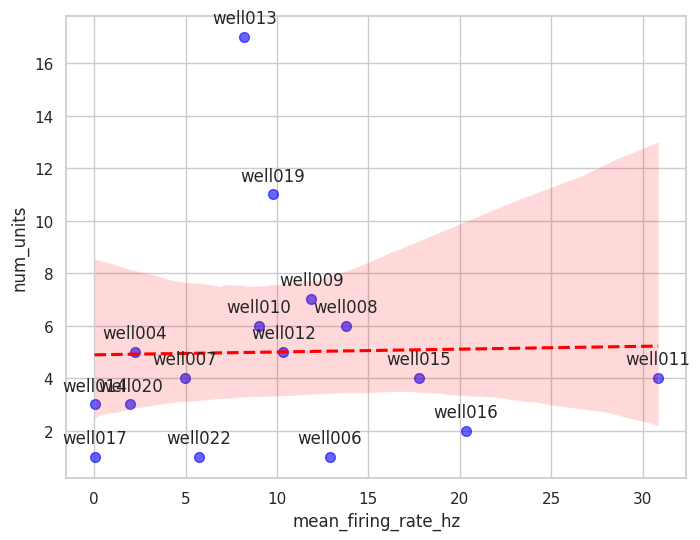

In [21]:
print(well_metrics)

plt.figure(figsize=(8, 6)) # Optional: Set the figure size
ax = sns.regplot(x='mean_firing_rate_hz', y='num_units', data=well_metrics, scatter_kws={'alpha': 0.6, 's': 50, 'color': 'blue'}, line_kws={'color': 'red', 'linestyle': '--'})
for i, row in well_metrics.iterrows():
    ax.annotate(row['well'],  # The text to display (well identifier)
                (row['mean_firing_rate_hz'], row['num_units']),  # The point to annotate
                textcoords="offset points",  # How to position the text
                xytext=(0, 10),  # Distance from the point (x, y)
                ha='center')  # Horizontal alignment of the text
    
plt.show()

In [ ]:
# Save the metrics to CSV files
full_df.to_csv(CSV_DIR / "full_df.csv", index=False)
analysis_df.to_csv(CSV_DIR / "analysis_df.csv", index=False)
unit_metrics.to_csv(CSV_DIR / "unit_metrics.csv", index=False)
well_metrics.to_csv(CSV_DIR / "well_metrics.csv", index=False)
well_intrinsic_cv_metrics.to_csv(CSV_DIR / "well_intrinsic_cv_metrics.csv", index=False)


Generating plots...


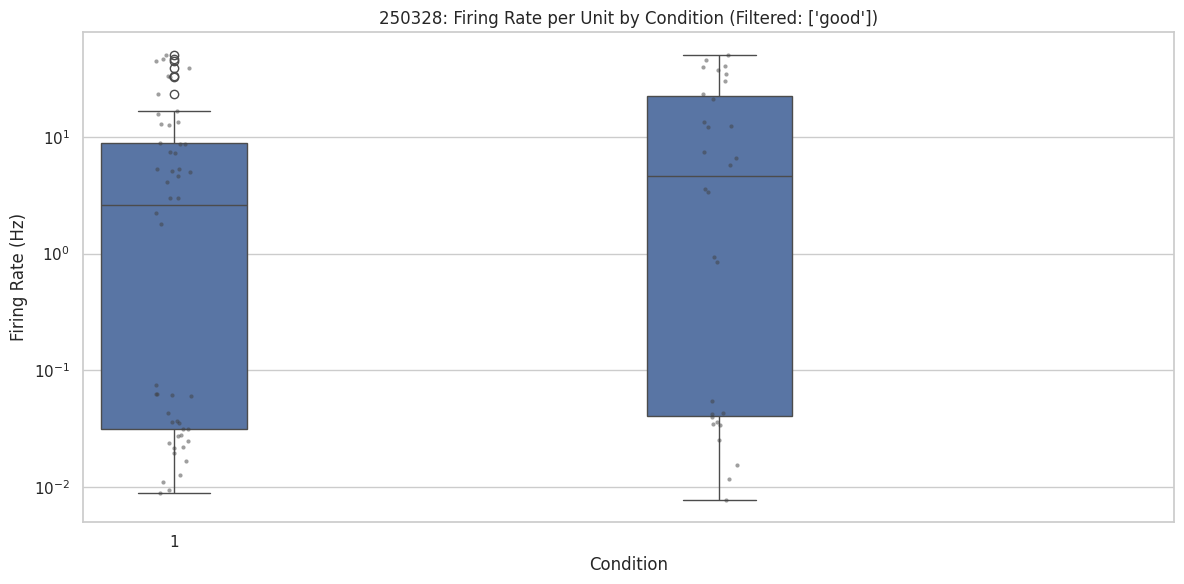

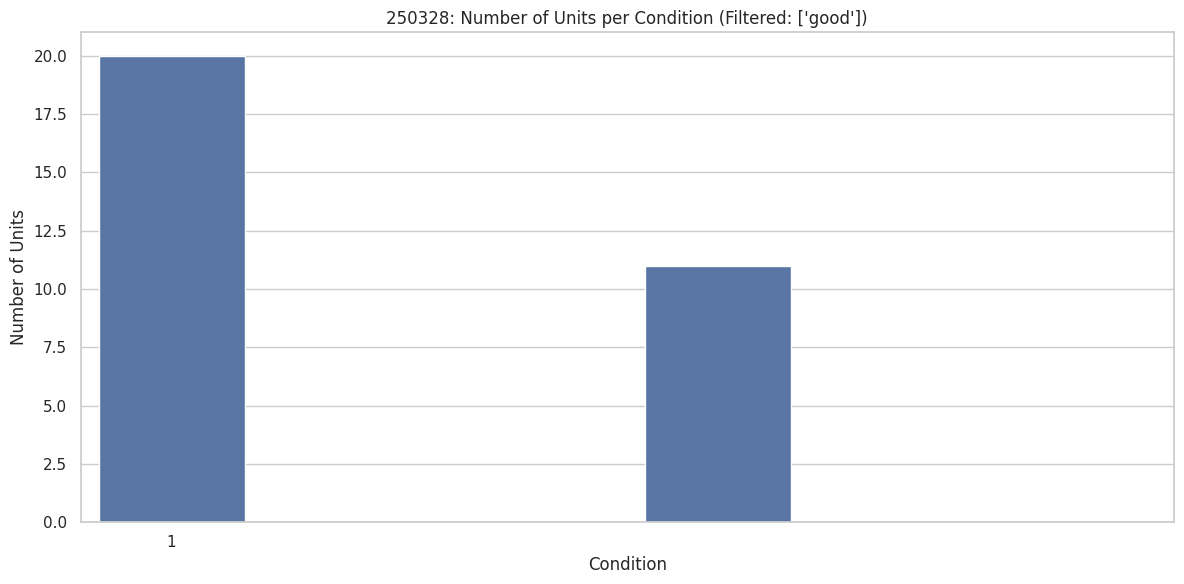

In [10]:
visualize_per_week(unit_metrics, WEEKS, CONDITIONS, QUALITY_FILTER, FIGURE_DIR, fr=True, num_units=True, save_figures=True)
# visualize_cluster_across_weeks(unit_metrics, WEEKS, CONDITIONS, QUALITY_FILTER, FIGURE_DIR, COLORING, fr=True, num_units=True, amplitude=False, save_figures=True)
# visualize_well_across_weeks(well_metrics, WEEKS, CONDITIONS, QUALITY_FILTER, FIGURE_DIR, COLORING, fr=True, num_units=True, save_figures=True)
# visualize_well_cv(well_intrinsic_cv_metrics, WEEKS, CONDITIONS, QUALITY_FILTER, FIGURE_DIR, COLORING, save_figures=True)